In [4]:
cd /home/ec2-user/SageMaker/VIP-Dementia

/home/ec2-user/SageMaker/VIP-Dementia


In [5]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 3.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 6.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 9.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 3.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 23.3 MB/s eta 0:00:00
  Created wheel for iso-639: filename=iso_6

In [6]:
cd /home/ec2-user/SageMaker/VIP-Dementia/audio_processing

/home/ec2-user/SageMaker/VIP-Dementia/audio_processing


In [36]:
import os
import pandas as pd
import librosa
import opensmile
from tqdm import tqdm

HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
RAW_DATA_DIR = os.path.join(HOME_DIRECTORY, 'data/raw')
PROCESSED_DATA_DIR = os.path.join(HOME_DIRECTORY, 'data/processed')
FEATURES_DIR = os.path.join(PROCESSED_DATA_DIR, 'features')
LABELS_DIR = os.path.join(PROCESSED_DATA_DIR, 'labels')

# Label mapping for binary classification
label_dict = {'CN': 0, 'AD': 1}

def get_features(audio_path, sample_rate=16000):
    """
    Extract features for the entire audio file at a specified sampling rate.

    :param audio_path: Path to the audio file.
    :param sample_rate: Desired sampling rate (in Hz).
    :return: DataFrame containing extracted features.
    """
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    try:
        # Load the entire audio file at the specified sampling rate (window size)
        y, sr = librosa.load(audio_path, sr=sample_rate)
        features_df = smile.process_signal(y, sr)
        return features_df
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return pd.DataFrame()

def load_audio_data(sample_rate=16000):
    X, y = [], []
    partitions = ['ad', 'cn']
    for partition in partitions:
        audio_dir = os.path.join(RAW_DATA_DIR, 'audio', partition)
        audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]
        with tqdm(total=len(audio_files), desc=f"Processing {partition.upper()} files") as pbar:
            for audio_path in audio_files:
                df = get_features(audio_path, sample_rate)
                if not df.empty:
                    X.append(df)
                    y.append(label_dict[partition.upper()])
                pbar.update(1)
    print(f"Finished processing {len(X)} files. Type of X: {type(X)}")
    return X, y

In [17]:
X, y = load_audio_data()

Processing CN files: 100%|██████████| 79/79 [03:49<00:00,  2.91s/it]

Finished processing 166 files. Type of X: <class 'list'>, Type of X[0]: <class 'pandas.core.frame.DataFrame'>


In [19]:
from sklearn.model_selection import train_test_split


features_df = pd.concat(X, ignore_index=True)
labels_series = pd.Series(y)
print(f'\nAudio samples represented: {len(X)}')  # Total number of audio files processed
print(f'Numerical features extracted per sample: {features_df.shape[1]}')
print(f'Unique labels in dataset: {labels_series.unique()}')

# Display the first few rows of the features DataFrame to check the data
features_df.head()

# Assuming 'features_df' and 'labels_series' are already defined and contain all your data
X = features_df
y = labels_series

# First, split into a training and a temp set (combining validation and test) with an 80/20 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then split the temp set equally into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display sizes of the datasets
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_valid.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Audio samples represented: 166
Numerical features extracted per sample: 88
Unique labels in dataset: [1 0]
Training set size: 132
Validation set size: 17
Test set size: 17


In [21]:
import numpy as np

# Specify the directory where you want to save the files
HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
save_dir = os.path.join(HOME_DIRECTORY, 'data/processed')

# Function to save datasets
def save_dataset(filename, dataset):
    path = os.path.join(save_dir, filename)
    np.save(path, dataset)
    print(f"Saved {filename} to {save_dir}")

# Saving each dataset
save_dataset('X_train.npy', X_train)
save_dataset('X_valid.npy', X_valid)
save_dataset('X_test.npy', X_test)
save_dataset('y_train.npy', y_train)
save_dataset('y_valid.npy', y_valid)
save_dataset('y_test.npy', y_test)


Saved X_train.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved X_valid.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved X_test.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved y_train.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved y_valid.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved y_test.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed


In [34]:
import os
import numpy as np

# Specify the directory where you want to save the files
HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
save_dir = os.path.join(HOME_DIRECTORY, 'data/processed/eGeMAPSv2/16000')
SPLIT_DATA_DIR = save_dir

# Function to load datasets
def load_dataset(filename):
    path = os.path.join(SPLIT_DATA_DIR, filename)
    if os.path.exists(path):
        return np.load(path, allow_pickle=True)
    else:
        print(f"File {filename} not found in {SPLIT_DATA_DIR}. Please check the directory and try again.")
        return None

# Loading each dataset
X_train = load_dataset('X_train.npy')
X_valid = load_dataset('X_valid.npy')
X_test = load_dataset('X_test.npy')
y_train = load_dataset('y_train.npy')
y_valid = load_dataset('y_valid.npy')
y_test = load_dataset('y_test.npy')

# Verifying the shapes of the loaded datasets (if they were successfully loaded)
if X_train is not None and y_train is not None:
    print(f"Loaded X_train: {X_train.shape}, y_train: {y_train.shape}")
if X_valid is not None and y_valid is not None:
    print(f"Loaded X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
if X_test is not None and y_test is not None:
    print(f"Loaded X_test: {X_test.shape}, y_test: {y_test.shape}")


Loaded X_train: (132, 88), y_train: (132,)
Loaded X_valid: (17, 88), y_valid: (17,)
Loaded X_test: (17, 88), y_test: (17,)


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),
    SVC(kernel='linear'),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

scores = []
for model in classification_models:
    try:
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        model_name = type(model).__name__
        if isinstance(model, SVC) and model.kernel == 'rbf':
            model_name += ' RBF kernel'
        scores.append((model_name, f'{100*score:.2f}%'))
    except ValueError as e:
        print(f"Error training {type(model).__name__}: {str(e)}")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [30]:
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
4,RandomForestClassifier,88.24%
6,GaussianNB,76.47%
1,SVC,70.59%
3,DecisionTreeClassifier,64.71%
7,QuadraticDiscriminantAnalysis,64.71%
5,AdaBoostClassifier,58.82%
0,KNeighborsClassifier,52.94%
2,SVC RBF kernel,52.94%


Matplotlib is building the font cache; this may take a moment.


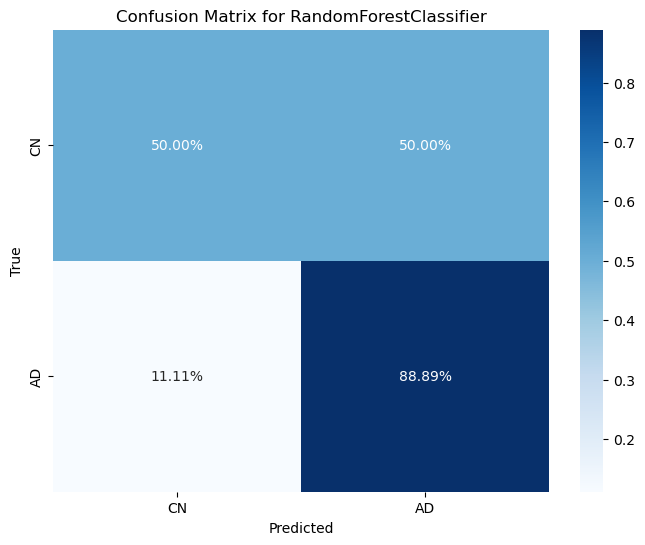

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

def plot_confusion_matrix(clf, X_test, y_test, class_names):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convert counts to percentage
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Larger figure size for better readability
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.title(f'Confusion Matrix for {type(clf).__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

# Example usage with class names
class_names = ['CN', 'AD']  # Ensure class names are in the order of your actual labels
plot_confusion_matrix(RandomForestClassifier().fit(X_train, y_train), X_test, y_test, class_names)


In [32]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
print(f'Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%') #same as model.score(X_test, y_test)
print(f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  64.706%
Test Set Precision score =  65.152%
Test Set Recall score =  63.889%
Test Set F-score score =  63.6%
